# Camera Self Calibration

## Generate data

In [1]:
import os
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from scipy.interpolate import griddata
from tqdm import tqdm
from itertools import repeat

# import the necessary modules
from zodipol.utils.argparser import ArgParser
from zodipol.zodipol import Zodipol, Observation
from zodipol.estimation.estimate_signal import estimate_IQU
from zodipol.zodipy_local.zodipy.zodipy import IQU_to_image

In [2]:
# magics
%reload_ext autoreload
%autoreload 2

In [3]:
parser = ArgParser(args=['-res', '300', '200', '--fov', '5', '-dir', '90', '40', '-par', '-ip', 'exposure_time', '10*u.s', '-nr', '1', '--isl'])

In [4]:
zodipol = Zodipol(polarizance=parser["polarizance"], fov=parser["fov"], n_polarization_ang=parser["n_polarization_ang"], parallel=parser["parallel"], n_freq=parser["n_freq"], planetary=parser["planetary"], isl=parser["isl"], resolution=parser["resolution"], imager_params=parser["imager_params"])

## Internal Fucntions

In [5]:
def get_images(obs_est_rot, polarization_angle, polarizance, zodipol, parser, disable=False):
    img_list = []
    for ii in tqdm(range(len(obs_est_rot)), disable=disable):
        p, pa, roll = polarizance[..., ii], polarization_angle[..., ii], obs_est_rot[ii].roll
        # p = get_rotated_image(zodipol, p, parser, -np.rad2deg(roll))
        # pa = get_rotated_image(zodipol, pa, parser, -np.rad2deg(roll))
        I, Q, U = obs_est_rot[ii].I, obs_est_rot[ii].Q, obs_est_rot[ii].U
        cur_img = IQU_to_image(I, Q, U, p, pa + roll)
        img_list.append(cur_img)
    # roll_arr = np.array([o.roll for o in obs_est_rot])
    img_stack = np.stack(img_list, axis=-1)
    # img_align = align_images(zodipol, parser, img_stack, -np.rad2deg(roll_arr))
    return img_stack

def estimate_polarizance(obs_est_rot, images_orig, polarization_angle, zodipol, parser, disable=False):
    # perform grid search for the polarizance
    p_t = np.linspace(0.5, 1, 21)
    img_list = []
    for ii in tqdm(range(len(obs_est_rot)), disable=disable):
        pa, roll = polarization_angle[..., ii], obs_est_rot[ii].roll
        # pa = get_rotated_image(zodipol, pa, parser, -np.rad2deg(roll))
        I, Q, U = obs_est_rot[ii].I, obs_est_rot[ii].Q, obs_est_rot[ii].U
        cur_img = np.stack([IQU_to_image(I, Q, U, p, pa + roll) for p in p_t], axis=-1)
        img_list.append(cur_img)
    img_stack = np.stack(img_list, axis=-2)
    diff_resh = (img_stack - images_orig[..., None]).reshape(parser["resolution"] + list(img_stack.shape[1:]))

    c = np.nansum((1e23 * diff_resh) ** 2, axis=(-3))
    p_est = p_t[np.argmin(np.nan_to_num(c, nan=np.inf), axis=-1)]
    return p_est

def estimate_polarization_angle(obs_est_rot, images_orig, polarizance, zodipol, parser, disable=False):
    a_t = np.deg2rad(np.linspace(-10, 10, 21))
    base_polarization_ang = parser["polarization_angle"][None, ...]
    img_list = []
    for ii in tqdm(range(len(obs_est_rot)), disable=disable):
        p, roll = polarizance[..., ii], obs_est_rot[ii].roll
        I, Q, U = obs_est_rot[ii].I, obs_est_rot[ii].Q, obs_est_rot[ii].U
        cur_img = np.stack([IQU_to_image(I, Q, U, p[..., None], base_polarization_ang + pa + roll) for pa in a_t], axis=-1)
        img_list.append(cur_img)
    img_stack = np.stack(img_list, axis=-2)
    diff_resh = (img_stack - images_orig[..., None]).reshape(parser["resolution"] + list(img_stack.shape[1:]))

    c = np.nansum((1e21 * diff_resh) ** 2, axis=(-3))
    p_est = a_t[np.argmin(np.nan_to_num(c, nan=np.inf), axis=-1)]
    return p_est

def estimate_observations(zodipol, parser, roll_list, images, polarizance, angles, theta, phi):
    est_shape = (images.shape[0], np.prod(images.shape[1:]))
    I_est, Q_est, U_est = estimate_IQU(images.reshape(est_shape), polarizance.reshape(est_shape), angles.reshape(est_shape))
    obs_est = Observation(I_est, Q_est, U_est, theta=theta, phi=phi, roll=0)
    obs_est_rot = list(map(realign_observation, repeat(zodipol), repeat(parser), repeat(obs_est), roll_list))
    return obs_est_rot

def get_rotated_image(zodipol, images, parser, rotation_to):
    if rotation_to == 0:  # avoid interpolation issues
        return images
    theta_from, phi_from = zodipol._create_sky_coords(theta=parser["direction"][0], phi=parser["direction"][1], roll=0 * u.deg, resolution=parser["resolution"])
    theta_to, phi_to = zodipol._create_sky_coords(theta=parser["direction"][0], phi=parser["direction"][1], roll=-rotation_to * u.deg, resolution=parser["resolution"])
    interp = griddata(points=np.stack((theta_from, phi_from), axis=-1).value, values=images, xi=np.stack((theta_to, phi_to), axis=-1).value, method='linear', fill_value=np.nan)
    return interp

def align_images(zodipol, parser, images_res, rotation_arr, invert=False):
    if invert:
        rotation_arr = -rotation_arr
    res_images = []
    for ii in range(images_res.shape[-1]):
        rot_image = get_rotated_image(zodipol, images_res[..., ii], parser, rotation_arr[ii])
        res_images.append(rot_image)
    return np.stack(res_images, axis=-1)

def realign_observation(zodipol, parser, obs, roll):
    I_interp = get_rotated_image(zodipol, obs.I, parser, -roll)
    Q_interp = get_rotated_image(zodipol, obs.Q, parser, -roll)
    U_interp = get_rotated_image(zodipol, obs.U, parser, -roll)
    return Observation(I_interp, Q_interp, U_interp, theta=obs.theta, phi=obs.phi, roll=np.deg2rad(roll))

def generate_observations(zodipol, parser):
    rotations_file_path = 'saved_models/self_calibration_temp.pkl'
    if os.path.isfile(rotations_file_path):
        # saved rotations pickle file exists
        with open(rotations_file_path, 'rb') as f:
            obs_rot = pkl.load(f)
        n_rotations = len(obs_rot)
    else:
        n_rotations = 13
        rotation_list = np.linspace(0, 360, n_rotations, endpoint=False)
        obs_rot = [zodipol.create_observation(theta=parser["direction"][0], phi=parser["direction"][1], roll=t * u.deg,
                                              lonlat=False, new_isl=parser["new_isl"]) for t in tqdm(rotation_list)]
        with open(rotations_file_path, 'wb') as f:
            pkl.dump(obs_rot, f)

    # create satellite polarizance and angle of polarization variables
    polarization_angle = parser["polarization_angle"]
    _, polarization_angle_spatial_diff = np.meshgrid(np.arange(parser["resolution"][0]),
                                                     np.deg2rad(np.linspace(-10, 10, parser["resolution"][1])),
                                                     indexing='ij')

    # polarization_angle_spatial_diff = 5 * np.ones_like(polarization_angle_spatial_diff)  # TODO: remove this
    pa_ts_diff = polarization_angle_spatial_diff.flatten()[:, None, None][..., None] * np.linspace(0, 1, n_rotations)
    polarization_angle_real = polarization_angle[None, None, :, None] + pa_ts_diff

    polarizance, _ = np.meshgrid(np.linspace(-1, 0, parser["resolution"][0]), np.arange(parser["resolution"][1]),
                                 indexing='ij')
    # polarizance = np.full_like(polarizance, -1)  # TODO: remove this later
    polarizance_real = polarizance.reshape((len(obs_rot[0]), 1, 1))
    polarizance_real = 0.9 + polarizance_real[..., None] * np.linspace(0, 0.2, n_rotations)

    # create observations images
    obs_orig = []
    for ii in range(n_rotations):
        o = obs_rot[ii]
        cur_obs_img = zodipol.make_camera_images(o, polarizance_real[..., ii], polarization_angle_real[..., ii],
                                                 n_realizations=1, add_noise=False)
        obs_orig.append(cur_obs_img)
    images_orig = np.stack(obs_orig, axis=-1)
    images_res = images_orig.reshape((parser["resolution"] + list(images_orig.shape[1:])))
    return images_res, polarizance_real, polarization_angle_real

In [6]:
def get_iteration_cost(polarizance_real, polarizance_est_reshape_nan, polarization_angle_real, polarization_ang_full_nan):
    p_pdiff = polarizance_real.squeeze()[:, 0, None] - polarizance_real.squeeze()
    p_estdiff = polarizance_est_reshape_nan[:, 0, 0, None] - polarizance_est_reshape_nan[:, 0, :]

    eta_pdiff = polarization_angle_real.squeeze()[:, 0, 0, None] - polarization_angle_real.squeeze()[:, 0, :]
    eta_estdiff = polarization_ang_full_nan[:, 0, 0, None] - polarization_ang_full_nan[:, 0, :]

    p_mse = np.nanmean((p_pdiff - p_estdiff)**2)
    eta_mse = np.nanmean((eta_pdiff - eta_estdiff)**2)
    return p_mse, eta_mse

## Generate Observations

In [10]:
images_res, polarizance_real, polarization_angle_real = generate_observations(zodipol, parser)

n_pixels = np.prod(parser["resolution"])
n_rotations = images_res.shape[-1]
rotation_list = np.linspace(0, 360, n_rotations, endpoint=False)
polarization_angle = parser["polarization_angle"]

In [11]:
# reshape images
images_res_flat = images_res.reshape((np.prod(parser["resolution"]), parser["n_polarization_ang"], n_rotations))

# Align generated images to the first image
theta0, phi0 = zodipol._create_sky_coords(theta=parser["direction"][0], phi=parser["direction"][1], roll=0 * u.deg, resolution=parser["resolution"])
interp_images_res = align_images(zodipol, parser, images_res_flat.value, rotation_list)

In [12]:
nan_ind = np.isnan(interp_images_res).any(axis=-1, keepdims=True)

In [13]:
# set estimation initial values
init_polarizance, init_polarization_ang = np.ones(parser["resolution"]), np.zeros(parser["resolution"])
polarizance_est = np.ones((n_pixels, n_rotations))
polarization_ang_est = np.zeros((n_pixels, n_rotations))

polarization_ang_full = polarization_ang_est[..., None, :] + polarization_angle[:, None]
polarization_ang_align = align_images(zodipol, parser, polarization_ang_full, rotation_list)
polarization_ang_rot = polarization_ang_align + np.deg2rad(rotation_list[None, None, :])

polarizance_est_reshape = np.broadcast_to(polarizance_est[..., None, :], polarization_ang_rot.shape)
polarizance_est_align = align_images(zodipol, parser, polarizance_est_reshape, rotation_list)

## Calibration Process

In [14]:
cost_itr = {'total': [], 'polarizance': [], 'polarization_ang': []}
max_itr = 15
for ii in tqdm(range(max_itr)):
    # estimate observations
    rotation_list = np.linspace(0, 360, n_rotations, endpoint=False)
    obs_est_rot = estimate_observations(zodipol, parser, rotation_list, interp_images_res,
                                        polarizance_est_align, polarization_ang_rot, theta0, phi0)

    # estimate polarizance and angle of polarization
    est_pol = estimate_polarizance(obs_est_rot[1:], images_res_flat.value[..., 1:], polarization_ang_full[..., 1:], zodipol, parser, disable=True)
    est_pol = np.concatenate((init_polarizance[..., None], est_pol), axis=-1)
    polarizance_est_reshape = np.broadcast_to(est_pol.reshape((n_pixels, 1, n_rotations)), polarization_ang_rot.shape)
    polarizance_est_align = align_images(zodipol, parser, polarizance_est_reshape, rotation_list)

    est_pa = estimate_polarization_angle(obs_est_rot[1:], images_res_flat.value[..., 1:], polarizance_est[..., 1:], zodipol, parser, disable=True)
    est_pa = np.concatenate((init_polarization_ang[..., None], est_pa), axis=-1)
    polarization_ang_est = est_pa.reshape((n_pixels, n_rotations))
    polarization_ang_full = polarization_ang_est[..., None, :] + polarization_angle[:, None]
    polarization_ang_align = align_images(zodipol, parser, polarization_ang_full, rotation_list)
    polarization_ang_rot = polarization_ang_align + np.deg2rad(rotation_list[None, None, :])

    polarizance_est_reshape_nan = np.where(nan_ind, np.nan, polarizance_est_reshape)
    polarization_ang_full_nan = np.where(nan_ind, np.nan, polarization_ang_full)

    est_images = get_images(obs_est_rot, polarization_ang_full_nan, polarizance_est_reshape_nan, zodipol, parser, disable=True)
    cost = np.nanmean(1e23 * (images_res_flat.value - est_images) ** 2)
    polarizance_cost, polarization_ang_cost = get_iteration_cost(polarizance_real, polarizance_est_reshape_nan, polarization_angle_real, polarization_ang_full_nan)
    # polarizance_cost = np.nanmean((polarizance_real.squeeze() - polarizance_est_reshape_nan[:, 0, :]) ** 2)
    # polarization_ang_cost =np.nanmean((polarization_angle_real.squeeze() - polarization_ang_full_nan) ** 2)
    # print(f"Iteration {ii}/{max_itr}: ", cost, polarizance_cost, polarization_ang_cost)
    cost_itr['total'].append(cost)
    cost_itr['polarizance'].append(polarizance_cost)
    cost_itr['polarization_ang'].append(polarization_ang_cost)

100%|██████████| 15/15 [21:39<00:00, 86.66s/it]


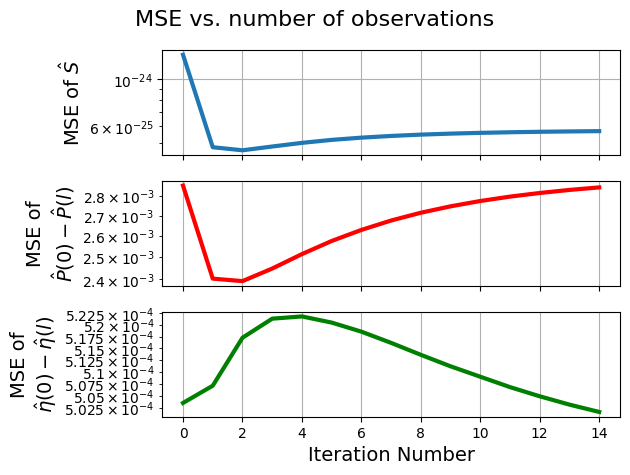

In [35]:
fig, (ax, ax2, ax3) = plt.subplots(3,1, sharex=True)
ax.semilogy( cost_itr['total'], label='Total MSE', lw=3)
ax2.semilogy(cost_itr['polarizance'], label='Polarizance MSE', color='r', lw=3)
ax3.semilogy(cost_itr['polarization_ang'], label='Polarizantion Angle MSE', color='g', lw=3)
# ax.yaxis.set_axis_formatter(FuncFormatter(lambda x, pos: '${0:.{2}f}\cdot10^{{{1:d}}}$'))

ax.set_ylabel('MSE of $\hat{S}$', fontsize=14)
ax2.set_ylabel('MSE of\n$\hat{P}(0) - \hat{P}(l)$', fontsize=14)
ax3.set_ylabel('MSE of\n$\hat{\eta}(0) - \hat{\eta}(l)$', fontsize=14)
ax3.set_xlabel('Iteration Number', fontsize=14)

ax.grid()
ax2.grid()
ax3.grid()
plt.suptitle('MSE vs. number of observations', fontsize=16)
fig.tight_layout()
fig.savefig(f"outputs/self_calib_mse_vs_nobs.pdf")
plt.show()

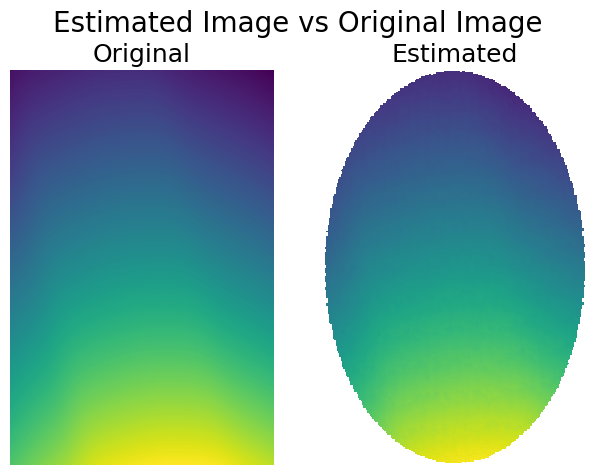

In [12]:
ii = 6
real = images_res_flat.value[:, 0, ii].reshape(parser["resolution"])
est = est_images[:, 0, ii].reshape(parser["resolution"])
imin, imax = real.min(), real.max()

# show an example for the image reconstruction
fig, ax = plt.subplots(1, 2)
c1 = ax[0].imshow(real.reshape(parser["resolution"]), origin='lower', vmin=imin, vmax=imax)
ax[0].set_title('Original', fontsize=18)
ax[0].set_axis_off()

c2 = ax[1].imshow(est.reshape(parser["resolution"]), origin='lower', vmin=imin, vmax=imax)
ax[1].set_title('Estimated', fontsize=18)
ax[1].set_axis_off()

plt.suptitle('Estimated Image vs Original Image', fontsize=20)
fig.tight_layout()
plt.savefig('outputs/self_calib_estimated_image.pdf')
plt.show()

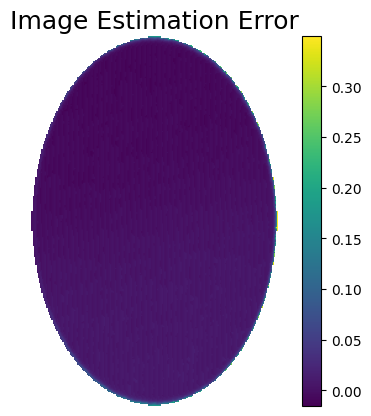

In [20]:
fig, ax = plt.subplots(1, 1)
c1 = ax.imshow((real-est).reshape(parser["resolution"]), origin='lower')
ax.set_title('Image Estimation Error', fontsize=18)
ax.set_axis_off()
plt.colorbar(c1, ax=ax)
plt.show()

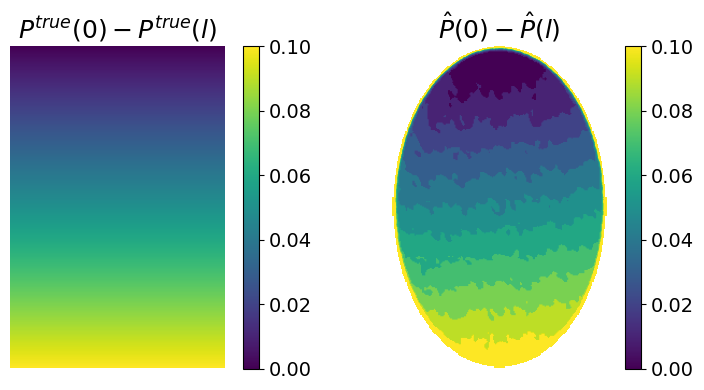

In [44]:
ii = 6
pdiff = polarizance_real.squeeze()[:, 0].reshape(parser["resolution"]) - polarizance_real.squeeze()[:, ii].reshape(parser["resolution"])
estdiff = polarizance_est_reshape_nan[:, 0, 0].reshape(parser["resolution"]) - polarizance_est_reshape_nan[:, 0, ii].reshape(parser["resolution"])
imin, imax = np.min(pdiff), np.max(pdiff)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
c1 = ax[0].imshow(pdiff.reshape(parser["resolution"]), origin='lower', vmin=imin, vmax=imax)
ax[0].set_title('$P^{true}(0)-P^{true}(l)$', fontsize=18)
ax[0].set_axis_off()
cb = plt.colorbar(c1, ax=ax[0])
cb.ax.tick_params(labelsize=14)

c2 = ax[1].imshow(estdiff.reshape(parser["resolution"]), origin='lower', vmin=imin, vmax=imax)
ax[1].set_title('$\hat{P}(0)-\hat{P}(l)$', fontsize=18)
ax[1].set_axis_off()
cb = plt.colorbar(c2, ax=ax[1])
cb.ax.tick_params(labelsize=14)

fig.tight_layout()
plt.savefig('outputs/self_calib_estimated_polarizance.pdf')
plt.show()

In [100]:
get_iteration_cost(polarizance_real, polarizance_est_reshape_nan, polarization_angle_real, polarization_ang_full_nan)

(0.002843930685861118, 0.0005016351329889595)

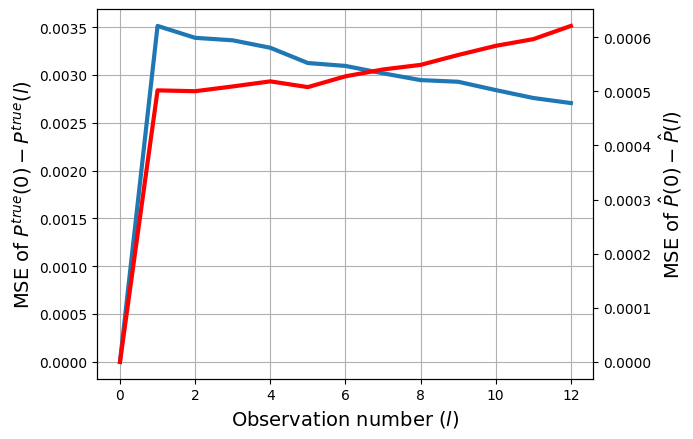

In [97]:
p_pdiff = polarizance_real.squeeze()[:, 0, None] - polarizance_real.squeeze()
p_estdiff = polarizance_est_reshape_nan[:, 0, 0, None] - polarizance_est_reshape_nan[:, 0, :]

eta_pdiff = polarization_angle_real.squeeze()[:, 0, 0, None] - polarization_angle_real.squeeze()[:, 0, :]
eta_estdiff = polarization_ang_full_nan[:, 0, 0, None] - polarization_ang_full_nan[:, 0, :]

p_bias = np.nanmean((p_pdiff - p_estdiff)**2, axis=0)
eta_bias = np.nanmean((eta_pdiff - eta_estdiff)**2, axis=0)

_, ax = plt.subplots(1,1)
ax.plot(p_bias, lw=3)
ax.grid()
ax2 = ax.twinx()
ax2.plot(eta_bias, lw=3, color='red')
ax.set_ylabel('MSE of $P^{true}(0)-P^{true}(l)$', fontsize=14)
ax.set_xlabel('Observation number $(l)$', fontsize=14)
ax2.set_ylabel('MSE of $\hat{P}(0)-\hat{P}(l)$', fontsize=14)
plt.show()

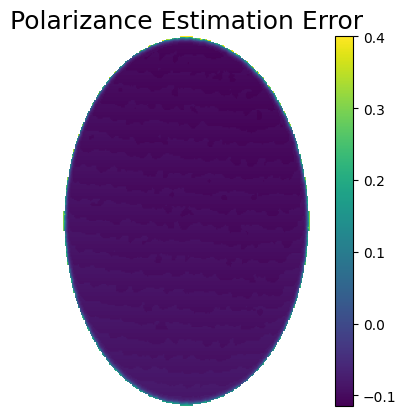

In [27]:
fig, ax = plt.subplots(1, 1)
c1 = ax.imshow((real-est).reshape(parser["resolution"]), origin='lower')
ax.set_title('Polarizance Estimation Error', fontsize=18)
ax.set_axis_off()
plt.colorbar(c1, ax=ax)
plt.show()

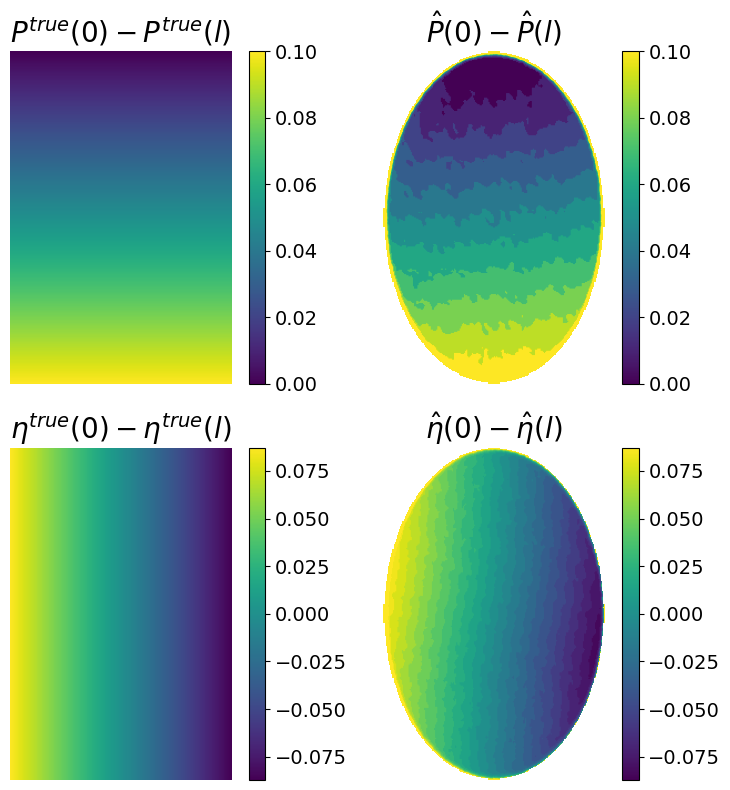

In [57]:
etadiff = polarization_angle_real.squeeze()[:, 0, 0].reshape(parser["resolution"]) - polarization_angle_real.squeeze()[:, 0, ii].reshape(parser["resolution"])
etaestdiff = polarization_ang_full_nan[:, 0, 0].reshape(parser["resolution"]) - polarization_ang_full_nan[:, 0, ii].reshape(parser["resolution"])


pdiff = polarizance_real.squeeze()[:, 0].reshape(parser["resolution"]) - polarizance_real.squeeze()[:, ii].reshape(parser["resolution"])
estdiff = polarizance_est_reshape_nan[:, 0, 0].reshape(parser["resolution"]) - polarizance_est_reshape_nan[:, 0, ii].reshape(parser["resolution"])
pimin, pimax = np.min(pdiff), np.max(pdiff)
eimin, eimax = np.min(etadiff), np.max(etadiff)

fig, ax = plt.subplots(2, 2, figsize=(8,8))
c1 = ax[0, 0].imshow(pdiff.reshape(parser["resolution"]), origin='lower', vmin=pimin, vmax=pimax)
ax[0, 0].set_title('$P^{true}(0)-P^{true}(l)$', fontsize=20)
ax[0, 0].set_axis_off()
cb = plt.colorbar(c1, ax=ax[0, 0])
cb.ax.tick_params(labelsize=14)

c2 = ax[0, 1].imshow(estdiff.reshape(parser["resolution"]), origin='lower', vmin=pimin, vmax=pimax)
ax[0, 1].set_title('$\hat{P}(0)-\hat{P}(l)$', fontsize=20)
ax[0, 1].set_axis_off()
cb = plt.colorbar(c2, ax=ax[0, 1])
cb.ax.tick_params(labelsize=14)

c1 = ax[1, 0].imshow(etadiff.reshape(parser["resolution"]), origin='lower', vmin=eimin, vmax=eimax)
ax[1, 0].set_title('$\eta^{true}(0)-\eta^{true}(l)$', fontsize=20)
ax[1, 0].set_axis_off()
cb = plt.colorbar(c1, ax=ax[1, 0])
cb.ax.tick_params(labelsize=14)

c2 = ax[1, 1].imshow(etaestdiff.reshape(parser["resolution"]), origin='lower', vmin=eimin, vmax=eimax)
ax[1, 1].set_title('$\hat{\eta}(0)-\hat{\eta}(l)$', fontsize=20)
ax[1, 1].set_axis_off()
cb = plt.colorbar(c2, ax=ax[1, 1])
cb.ax.tick_params(labelsize=14)

fig.tight_layout()
plt.savefig('outputs/self_calib_estimated_both.pdf')
plt.show()

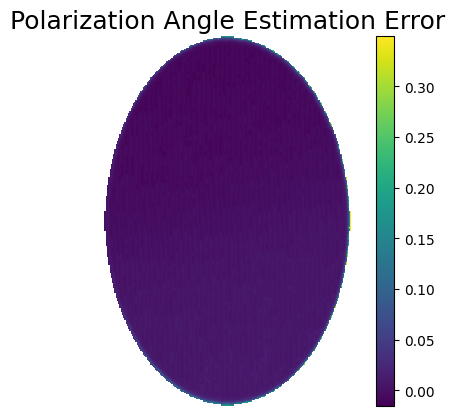

In [17]:
fig, ax = plt.subplots(1, 1)
c1 = ax.imshow((real-est).reshape(parser["resolution"]), origin='lower')
ax.set_title('Polarization Angle Estimation Error', fontsize=18)
ax.set_axis_off()
plt.colorbar(c1, ax=ax)
plt.show()

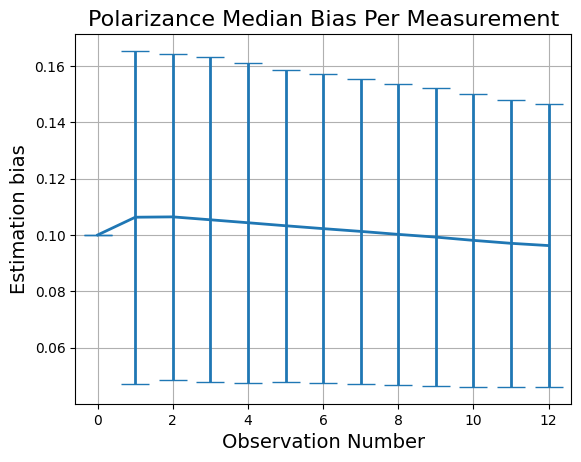

In [18]:
# estimation bias per measurement
x = np.arange(polarizance_real.shape[-1])
err = polarizance_est_reshape_nan[:, 0, :] - polarizance_real[..., 0, 0, :]
polarizance_bias = np.nanmedian(err, axis=0)
polarizance_std = np.nanstd(err, axis=0)

plt.figure()
plt.errorbar(x=x, y=polarizance_bias, yerr=polarizance_std, capsize=10, lw=2)
plt.grid()
plt.xlabel('Observation Number', fontsize=14)
plt.ylabel('Estimation bias', fontsize=14)
plt.title('Polarizance Median Bias Per Measurement', fontsize=16)
plt.show()

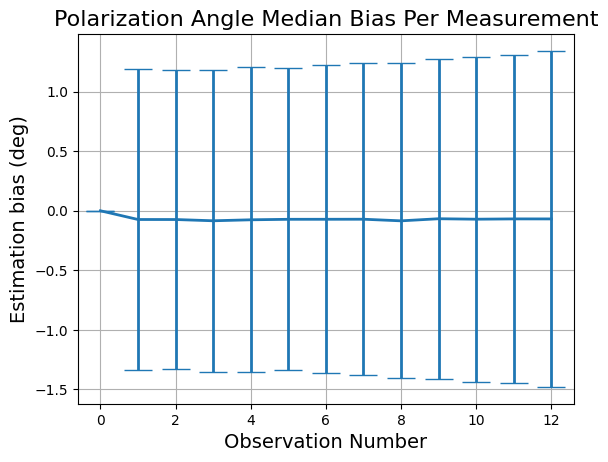

In [19]:
# estimation bias per measurement
x = np.arange(polarization_angle_real.shape[-1])
err = polarization_ang_full_nan[:, 0, :] - polarization_angle_real[..., 0, 0, :]
polari_ang_bias = np.rad2deg(np.nanmedian(err, axis=0))
polari_ang_std = np.rad2deg(np.nanstd(err, axis=0))

plt.figure()
plt.errorbar(x=x, y=polari_ang_bias, yerr=polari_ang_std, capsize=10, lw=2)
plt.grid()
plt.xlabel('Observation Number', fontsize=14)
plt.ylabel('Estimation bias (deg)', fontsize=14)
plt.title('Polarization Angle Median Bias Per Measurement', fontsize=16)
plt.show()

## Self calibration by exposure time

In [7]:
def get_iteration_cost(polarizance_real, polarizance_est_reshape_nan, polarization_angle_real, polarization_ang_full_nan):
    p_pdiff = polarizance_real.squeeze()[:, 0, None] - polarizance_real.squeeze()
    p_estdiff = polarizance_est_reshape_nan[:, 0, 0, None] - polarizance_est_reshape_nan[:, 0, :]

    eta_pdiff = polarization_angle_real.squeeze()[:, 0, 0, None] - polarization_angle_real.squeeze()[:, 0, :]
    eta_estdiff = polarization_ang_full_nan[:, 0, 0, None] - polarization_ang_full_nan[:, 0, :]

    p_mse = np.nanmean((p_pdiff - p_estdiff)**2)
    eta_mse = np.nanmean((eta_pdiff - eta_estdiff)**2)
    return p_mse, eta_mse


def get_measurements(zodipol, parser, n_rotations=40):
    rotations_file_path = 'saved_models/self_calibration_40.pkl'
    rotation_list = np.linspace(0, 360, n_rotations, endpoint=False)
    if os.path.isfile(rotations_file_path):
        # saved rotations pickle file exists
        with open(rotations_file_path, 'rb') as f:
            obs_rot = pkl.load(f)
        ind_list = np.linspace(0, len(obs_rot), n_rotations, endpoint=False, dtype=int)
        rotation_list = np.linspace(0, 360, len(obs_rot), endpoint=False)[ind_list]
        obs_rot = [obs_rot[ii] for ii in ind_list]
    else:
        obs_rot = [zodipol.create_observation(theta=parser["direction"][0], phi=parser["direction"][1], roll=t * u.deg,
                                              lonlat=False, new_isl=parser["new_isl"]) for t in tqdm(rotation_list)]
        with open(rotations_file_path, 'wb') as f:
            pkl.dump(obs_rot, f)
    return obs_rot, rotation_list


def generate_observations(zodipol, parser, n_rotations=40):
    motion_blur = 360 / n_rotations / zodipol.imager.exposure_time.value * u.deg
    obs_rot, rotation_list = get_measurements(zodipol, parser, n_rotations=n_rotations)
    obs_rot = [o.add_radial_blur(motion_blur, parser["resolution"]) for o in obs_rot]
    obs_rot = [o.add_direction_uncertainty(parser["fov"], parser["resolution"], parser["direction_uncertainty"]) for o in obs_rot]

    # create satellite polarizance and angle of polarization variables
    polarization_angle = parser["polarization_angle"]
    _, polarization_angle_spatial_diff = np.meshgrid(np.arange(parser["resolution"][0]),
                                                     np.deg2rad(np.linspace(-10, 10, parser["resolution"][1])),
                                                     indexing='ij')

    angular_amount = np.random.choice(np.linspace(-1, 1, n_rotations), size=(n_rotations), replace=False)
    pa_ts_diff = np.deg2rad(3) + polarization_angle_spatial_diff.flatten()[:, None, None][..., None] * angular_amount
    polarization_angle_real = polarization_angle[None, None, :, None] + pa_ts_diff

    polarizance, _ = np.meshgrid(np.linspace(-1, 0, parser["resolution"][0]), np.arange(parser["resolution"][1]),
                                 indexing='ij')
    polarizance_real = polarizance.reshape((len(obs_rot[0]), 1, 1))
    polariz_amount = np.random.choice(np.linspace(0, 0.4, n_rotations), size=(n_rotations), replace=False)
    polarizance_real = 0.9 + polarizance_real[..., None] * polariz_amount

    # create observations images
    obs_orig = [zodipol.make_camera_images(obs_rot[ii], polarizance_real[..., ii], polarization_angle_real[..., ii],
                                                 n_realizations=parser["n_realizations"], add_noise=True) for ii in range(n_rotations)]
    images_orig = np.stack(obs_orig, axis=-1)
    images_res = images_orig.reshape((parser["resolution"] + list(images_orig.shape[1:])))
    return images_res, rotation_list, polarizance_real, polarization_angle_real

def perform_estimation(zodipol, parser, rotation_list, images_res_flat, polarizance_real, polarization_angle_real,
                       disable=False, est_itr=6):
    n_pixels = np.prod(parser["resolution"])
    polarization_angle = parser["polarization_angle"]
    n_rotations = len(rotation_list)

    theta0, phi0 = zodipol._create_sky_coords(theta=parser["direction"][0], phi=parser["direction"][1], roll=0 * u.deg, resolution=parser["resolution"])
    interp_images_res = align_images(zodipol, parser, images_res_flat.value, rotation_list)
    nan_ind = np.isnan(interp_images_res).any(axis=-1, keepdims=True)

    polarizance_est = np.ones((n_pixels, n_rotations))
    polarization_ang_est = np.zeros((n_pixels, n_rotations))

    polarization_ang_full = polarization_ang_est[..., None, :] + polarization_angle[:, None]
    polarization_ang_align = align_images(zodipol, parser, polarization_ang_full, rotation_list)
    polarization_ang_rot = polarization_ang_align + np.deg2rad(rotation_list[None, None, :])

    polarizance_est_reshape = np.broadcast_to(polarizance_est[..., None, :], polarization_ang_rot.shape)
    polarizance_est_align = align_images(zodipol, parser, polarizance_est_reshape, rotation_list)

    # organize inputs for estimation
    cost_itr = {'total': [], 'polarizance': [], 'polarization_ang': []}
    for ii in tqdm(range(est_itr), disable=disable):
        # estimate observations
        obs_est_rot = estimate_observations(zodipol, parser, rotation_list, interp_images_res,
                                            polarizance_est_align, polarization_ang_rot, theta0, phi0)

        # estimate polarizance and angle of polarization
        est_pol = estimate_polarizance(obs_est_rot, images_res_flat.value, polarization_ang_full,
                                       zodipol, parser, disable=True)
        # est_pol = np.concatenate((init_polarizance[..., None], est_pol), axis=-1)
        polarizance_est_reshape = np.broadcast_to(est_pol.reshape((n_pixels, 1, n_rotations)),
                                                  polarization_ang_rot.shape)
        polarizance_est_align = align_images(zodipol, parser, polarizance_est_reshape, rotation_list)

        est_pa = estimate_polarization_angle(obs_est_rot, images_res_flat.value, polarizance_est,
                                             zodipol, parser, disable=True)
        # est_pa = np.concatenate((init_polarization_ang[..., None], est_pa), axis=-1)
        polarization_ang_est = est_pa.reshape((n_pixels, n_rotations))
        polarization_ang_full = polarization_ang_est[..., None, :] + polarization_angle[:, None]
        polarization_ang_align = align_images(zodipol, parser, polarization_ang_full, rotation_list)
        polarization_ang_rot = polarization_ang_align + np.deg2rad(rotation_list[None, None, :])

        est_images = get_images(obs_est_rot, polarization_ang_full, polarizance_est_reshape, zodipol, parser,
                                disable=True)
        cost = np.sqrt(np.nanmean(1e23 * (images_res_flat.value - est_images) ** 2))
        polarizance_cost = np.sqrt(np.sum((polarizance_real.squeeze() - polarizance_est_reshape[:, 0, :]) ** 2))
        polarization_ang_cost = np.sqrt(np.sum((polarization_angle_real.squeeze() - polarization_ang_full) ** 2))
        cost_itr['total'].append(cost)
        cost_itr['polarizance'].append(polarizance_cost)
        cost_itr['polarization_ang'].append(polarization_ang_cost)
    polarizance_est_reshape = np.where(nan_ind, np.nan, polarizance_est_reshape)
    polarization_ang_full = np.where(nan_ind, np.nan, polarization_ang_full)
    return cost_itr, polarizance_est_reshape, polarization_ang_full


In [ ]:
# generate observations
polariz_bias_l, pol_ang_bias_l  = [], []
rotation_cost_itr = []
n_rotations = 21
exposure_time_list = np.logspace(np.log10(0.1), np.log10(100), 12)

In [17]:
exposure_time_list_temp = exposure_time_list[len(polariz_bias_l):]

In [19]:
for exposure_time in exposure_time_list_temp:
    zodipol.imager.exposure_time = exposure_time * u.s
    images_res, rotation_list, polarizance_real, polarization_angle_real = generate_observations(zodipol, parser, n_rotations=n_rotations)
    images_res_flat = images_res.reshape((np.prod(parser["resolution"]), parser["n_polarization_ang"], n_rotations))
    cost_itr, polarizance_est_reshape, polarization_ang_full = perform_estimation(zodipol, parser, rotation_list, images_res_flat, polarizance_real, polarization_angle_real, est_itr=6)
    polarizance_cost, polarization_ang_cost = get_iteration_cost(polarizance_real, polarizance_est_reshape, polarization_angle_real, polarization_ang_full)
    polariz_bias_l.append(polarizance_cost)
    pol_ang_bias_l.append(polarization_ang_cost)
    rotation_cost_itr.append(cost_itr)

100%|██████████| 6/6 [17:56<00:00, 179.48s/it]


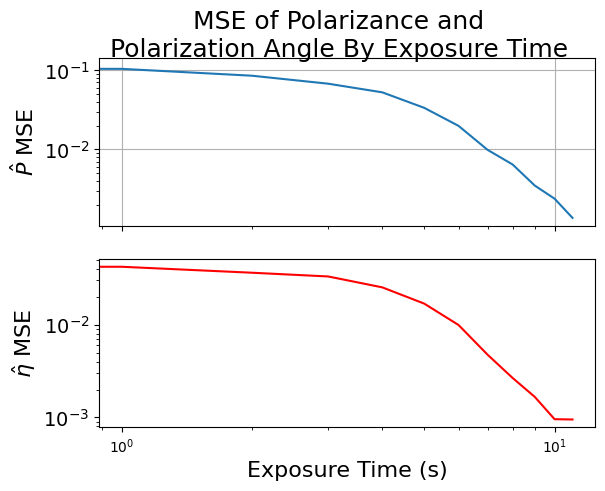

In [20]:
fig, (ax, ax2) = plt.subplots(2,1, sharex=True)
ax.loglog(polariz_bias_l)
ax2.loglog(pol_ang_bias_l, color='r')
ax.grid()
# ax.set_xlabel('Exposure Time (s)', fontsize=16)
ax2.set_xlabel('Exposure Time (s)', fontsize=16)
ax.set_ylabel('$\\hat{P}$ MSE', fontsize=16)
ax2.set_ylabel('$\\hat{\eta}$ MSE', fontsize=16)
ax.tick_params(axis='y', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
plt.suptitle('MSE of Polarizance and\nPolarization Angle By Exposure Time', fontsize=18)
plt.savefig('outputs/self_calib_cost_exposure_time.pdf')
plt.show()

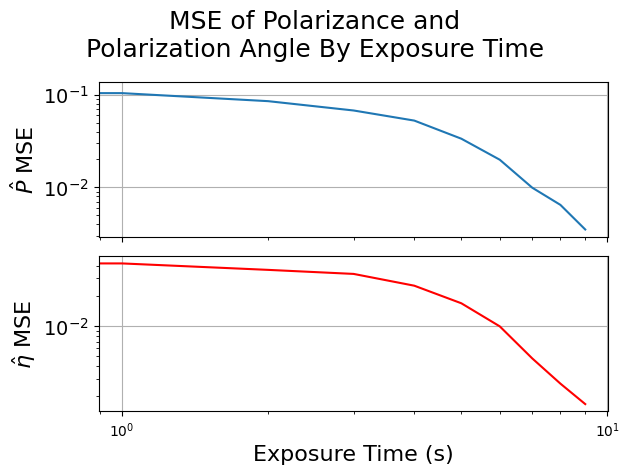

In [27]:
fig, (ax, ax2) = plt.subplots(2,1, sharex=True)
ax.loglog(polariz_bias_l[:-2])
ax2.loglog(pol_ang_bias_l[:-2], color='r')
ax.grid()
ax2.grid()
# ax.set_xlabel('Exposure Time (s)', fontsize=16)
ax2.set_xlabel('Exposure Time (s)', fontsize=16)
ax.set_ylabel('$\\hat{P}$ MSE', fontsize=16)
ax2.set_ylabel('$\\hat{\eta}$ MSE', fontsize=16)
ax.tick_params(axis='y', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
plt.suptitle('MSE of Polarizance and\nPolarization Angle By Exposure Time', fontsize=18)
fig.tight_layout()
plt.savefig('outputs/self_calib_cost_exposure_time.pdf')
plt.show()